## 0. Taula de Contiguts

- [EDA](#1.-EDA-(Exploratory-Data-Analysis))
  - [Anàlisi estadístic bàsic](#1.1-Anàlisi-estadístic-bàsic)
  

In [1]:
#%pip install pandas numpy matplotlib seaborn scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

## 1. EDA (Exploratory Data Analysis)

In [2]:
# Configuració visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Càrrega de dades
# Assegura't que el fitxer 'trs_train.csv' està al mateix directori
df = pd.read_csv('trs_train.csv')

print(f"Dimensions del dataset: {df.shape}")
display(df.head())

Dimensions del dataset: (9000, 28)


,patient_id,Age,Sex,Ethnicity,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,...,Polygenic_risk_score,Del_22q11_2_status,IL_17A,CCL23,TWEAK,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS
0,1,28.0,1,Caucasian,7.5,1,24.7,2.35,NaN,31.2,...,0.330,0,2.76,5.66,4.47,0.01147,0.01082,1.225,1.133,0
1,2,23.0,1,Asian,3.6,1,41.0,2.02,3.34,26.2,...,0.121,0,2.04,2.67,1.93,0.01386,0.01437,1.042,1.502,0
2,3,29.0,1,Caucasian,7.4,0,6.0,NaN,5.38,39.2,...,-0.098,0,1.55,2.31,2.92,0.01589,0.01632,1.728,1.842,0
3,4,36.0,0,Hispanic,5.5,0,43.4,1.60,6.84,31.5,...,0.019,0,1.77,2.37,4.26,0.01178,0.01154,1.399,1.249,0
4,5,23.0,0,Caucasian,4.5,0,86.1,NaN,3.18,29.6,...,-0.049,0,2.11,3.55,3.84,0.01209,0.01171,0.800,1.533,0


### 1.1 Anàlisi estadístic bàsic
Generem taula descriptiva amb estadístiques bàsiques i taxa de valors perduts per a cada variable. 

In [ ]:
stats_desc = df.describe().T
stats_desc['missing_rate'] = df.isnull().mean()
display(stats_desc)

Desbalanceig de la classe objectiu (TRS).



In [ ]:
ratio_trs = df['TRS'].value_counts(normalize=True)
print(f"Ratio de classes:\n{ratio_trs}")

Plotegem l'histograma de la variable objectiu TRS per visualitzar el desbalanceig de classes.

In [ ]:
# Visualització de l'histograma de la variable objectiu TRS
plt.figure()
sns.countplot(x='TRS', data=df, palette='viridis')
plt.title('Distribució de la variable objectiu TRS')
plt.xlabel('TRS')
plt.ylabel('Comptatge')
plt.show()

### 1.2 Recodificació de variables

Tenim dues variables categòriques representades amb símbols alfanumèrics que cal recodificar a valors numèrics per facilitar el processament en els models de machine learning. Aquestes són:

- ``Ethnicity``: Recodificarem les diferents categories ètniques a valors numèrics únics.
- ``CYP2D6_metabolic_phenotype``: Aquesta variable indica el fenotip metabòlic i també serà recodificada a valors numèrics.

Mirem quines categories tenim en cada variable:


In [3]:
col_recode = [ "Ethnicity", "CYP2D6_metabolic_phenotype" ]

for col in col_recode:
    print(f"\nCategories a recodificar per la variable '{col}':")
    print(df[col].value_counts())


Categories a recodificar per la variable 'Ethnicity':
Ethnicity
Caucasian    5408
African      1403
Asian        1305
Hispanic      884
Name: count, dtype: int64

Categories a recodificar per la variable 'CYP2D6_metabolic_phenotype':
CYP2D6_metabolic_phenotype
Extensive       6874
Intermediate    1114
Ultrarapid       570
Poor             442
Name: count, dtype: int64


Tenim les següents categories:

Per ``Ethnicity``: `African`, `Asian`, `Caucasian`, `Hispanic`
Per ``CYP2D6_metabolic_phenotype``: `Extensive`, `Intermediate`, `Poor`, `Ultrarapid`

Per recodificar `Ethnicity`, utilitzem una assignació hot-encoding, per no introduir un ordre artificial entre les categories. És a dir, creem una columna binària per a cada categoria ètnica.
Per recodificar `CYP2D6_metabolic_phenotype`, utilitzem una assignació ordinal, ja que hi ha un ordre natural entre els fenotips metabòlics. Assignem valors numèrics de la següent manera:
- Poor: 0
- Intermediate: 1
- Extensive: 2
- Ultrarapid: 3

Recodifiquem les variables al DataFrame:

In [4]:

cyp2d6_mapping = {
    'Poor': 0,
    'Intermediate': 1,
    'Extensive': 2,
    'Ultrarapid': 3
}

if 'CYP2D6_metabolic_phenotype' in df.columns:
    df['CYP2D6_encoded'] = df['CYP2D6_metabolic_phenotype'].map(cyp2d6_mapping)
    df = df.drop('CYP2D6_metabolic_phenotype', axis=1)
    
if 'Ethnicity' in df.columns:
    ethnicity_dummies = pd.get_dummies(df['Ethnicity'], prefix='is', dtype=int)
    df = pd.concat([df, ethnicity_dummies], axis=1)
    df = df.drop('Ethnicity', axis=1)
display(df.head(3))


,patient_id,Age,Sex,Duration_untreated_psychosis,Family_history,Initial_response,Lymphocyte_count,Neutrophil_count,BMI,Triglycerides,...,Ki_whole_striatum,Ki_associative_striatum,SUVRc_whole_striatum,SUVRc_associative_striatum,TRS,CYP2D6_encoded,is_African,is_Asian,is_Caucasian,is_Hispanic
0,1,28.0,1,7.5,1,24.7,2.35,NaN,31.2,230.6,...,0.01147,0.01082,1.225,1.133,0,2,0,0,1,0
1,2,23.0,1,3.6,1,41.0,2.02,3.34,26.2,58.9,...,0.01386,0.01437,1.042,1.502,0,2,0,1,0,0
2,3,29.0,1,7.4,0,6.0,NaN,5.38,39.2,NaN,...,0.01589,0.01632,1.728,1.842,0,1,0,0,1,0


### 1.3 Particionat

Cal particionar el dataset en train i test abans de fer qualsevol tipus de preprocessament per evitar data leakage. Utilitzem un 80% per a train i 20% per a test, assegurant-nos que la distribució de la variable objectiu (TRS) es manté en ambdós conjunts mitjançant estratificació.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('TRS', axis=1)
y = df['TRS']

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

partition_data = {
    'Partició': ['Train', 'Validació', 'Total'],
    'N': [len(y_train), len(y_val), len(y)],
    '%': [f"{len(y_train)/len(y)*100:.0f}%", f"{len(y_val)/len(y)*100:.0f}%", "100%"],
    'TRS=1': [y_train.sum(), y_val.sum(), y.sum()],
    'Prop. TRS=1': [f"{y_train.mean():.1%}", f"{y_val.mean():.1%}", f"{y.mean():.1%}"]
}

display(pd.DataFrame(partition_data))


,Partició,N,%,TRS=1,Prop. TRS=1
0,Train,7200,80%,2270,31.5%
1,Validació,1800,20%,568,31.6%
2,Total,9000,100%,2838,31.5%


### 1.4 Missing Values i Imputació

In [26]:
# Calculem missings totals i percentatge
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100

# Creem un DataFrame resum només amb les variables que tenen missings
missing_df = pd.DataFrame({
    'Total Missings': missing_data, 
    'Percentatge (%)': missing_percent
})

# Filtrem per mostrar només les que tenen algun missing i ordenem
missing_df = missing_df[missing_df['Total Missings'] > 0].sort_values(by='Percentatge (%)', ascending=False)

print("--- Resum de Valors Perduts ---")
if not missing_df.empty:
    display(missing_df.style.background_gradient(cmap='Reds'))
else:
    print("No queden valors perduts al dataset!")


--- Resum de Valors Perduts ---


,Total Missings,Percentatge (%)
Alkaline_phosphatase,2938,32.644444
Glucose,2619,29.100000
Triglycerides,2453,27.255556
Lymphocyte_count,1991,22.122222
Neutrophil_count,1985,22.055556
Duration_untreated_psychosis,128,1.422222
Polygenic_risk_score,1,0.011111
IL_17A,1,0.011111


Gestió de valors perduts:

1. Per la variable ``Duration_untreated_psychosis``, `Polygenic_risk_score` i `IL_17A` eliminem les files amb valors perduts, ja que en són pocs.

Per la resta de variables, utilitzem la imputació, i com són variables numèriques, utilitzem el mostreig aleatori que respecti la distribució original de cada variable.

In [24]:
import pandas as pd

cols_to_clean = ['Duration_untreated_psychosis', 'Polygenic_risk_score']

for col in cols_to_clean:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_val[col] = pd.to_numeric(X_val[col], errors='coerce')

X_train_clean = X_train.dropna(subset=cols_to_clean)
X_val_clean = X_val.dropna(subset=cols_to_clean)

y_train_clean = y_train.loc[X_train_clean.index]
y_val_clean = y_val.loc[X_val_clean.index]

X_train, y_train = X_train_clean, y_train_clean
X_val, y_val = X_val_clean, y_val_clean


Les variables numèriques perdudes són:
- ``Lymphocyte_count``
- ``Neutrophil_count``
- ``Triglycerides``
- ``Glucose``
- ``Alkaline_phosphatase``

Intenem visualitzar la distribució de les variables:


Generant gràfics per a 8 variables...



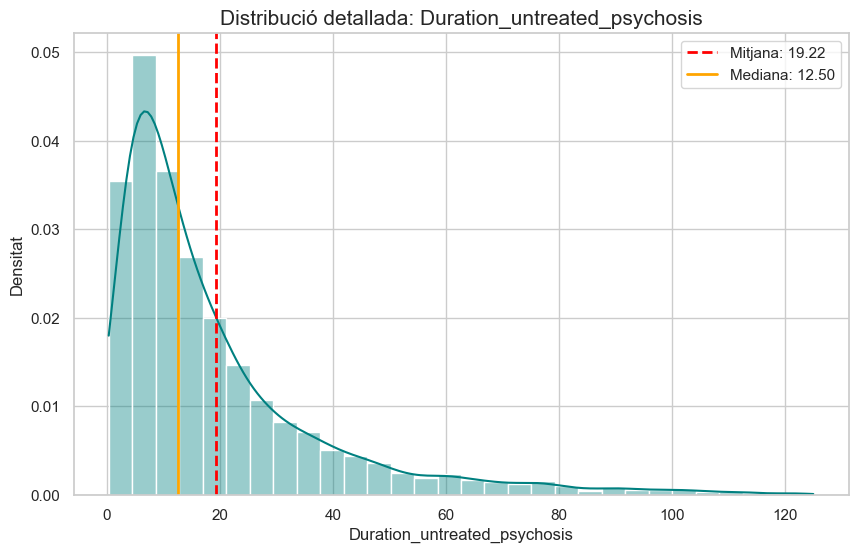

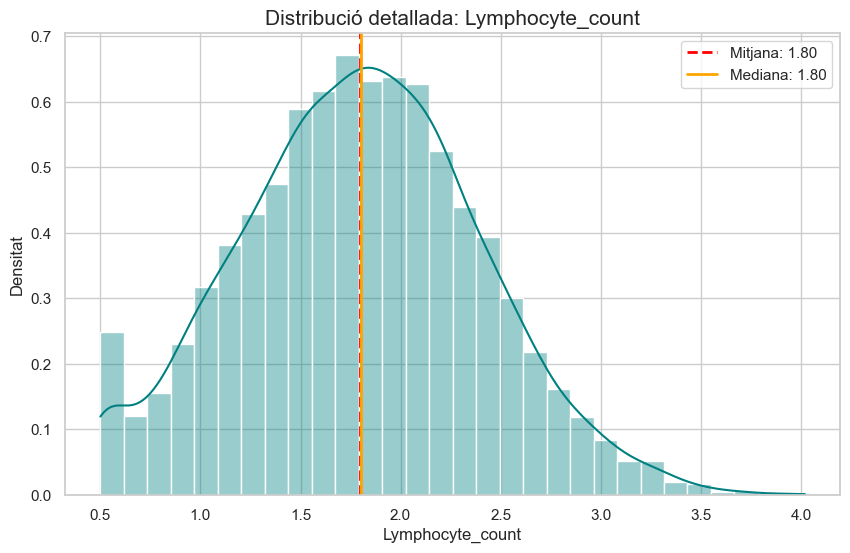

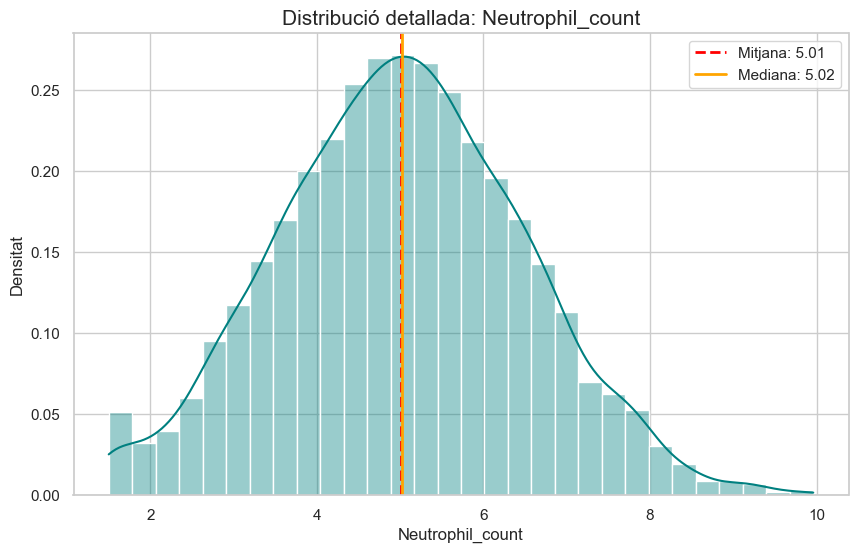

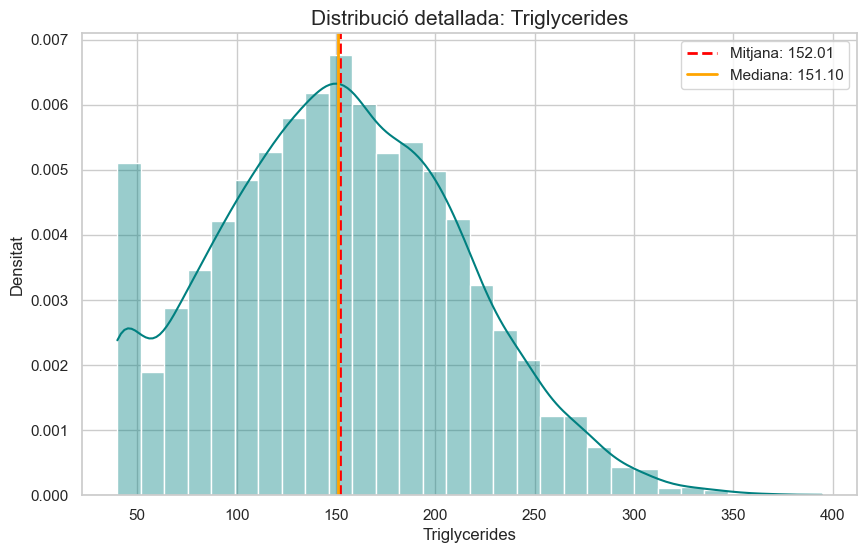

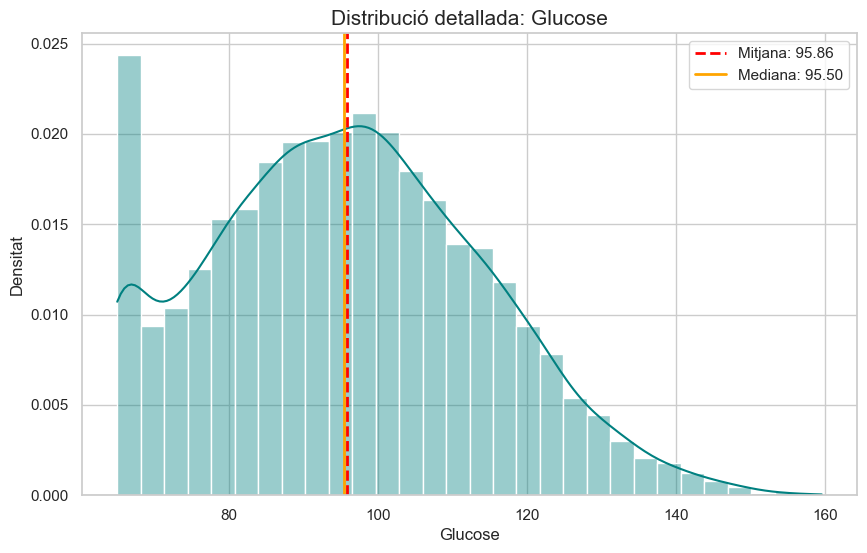

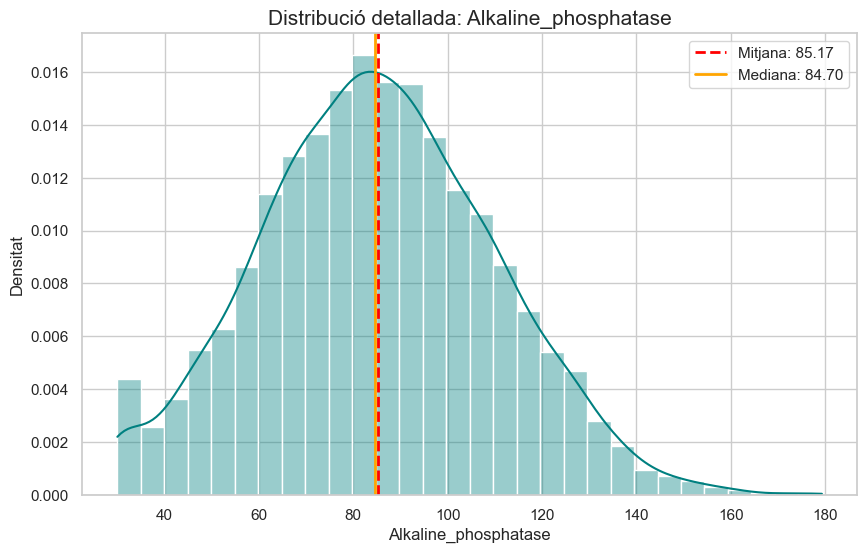

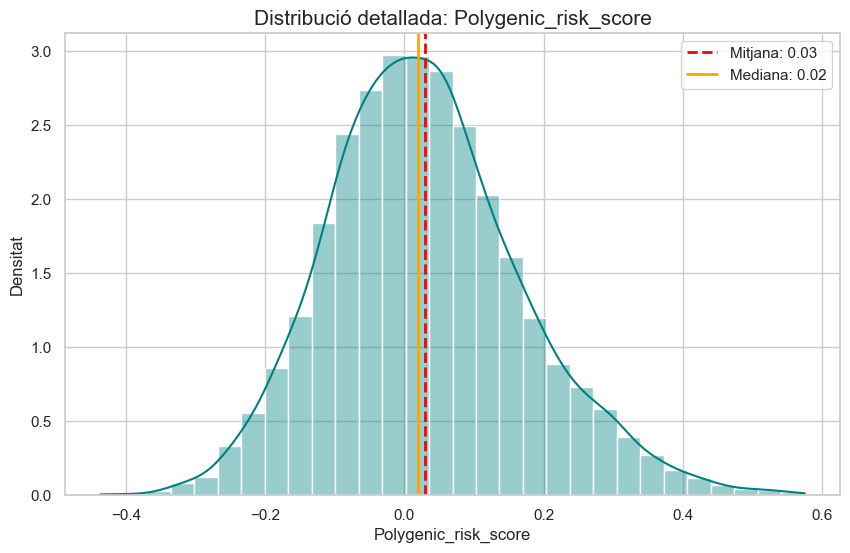

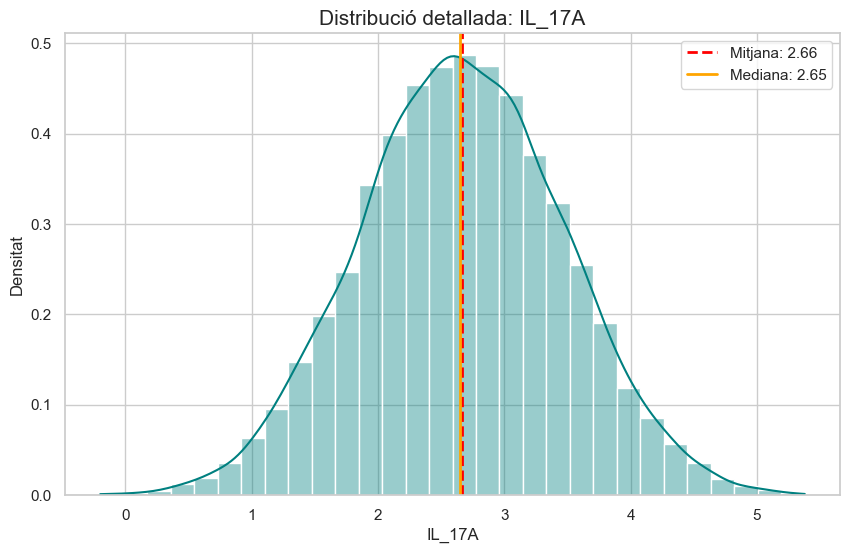

In [8]:
# Identifiquem columnes que encara tenen missings
cols_missing = [col for col in df.columns if df[col].isnull().any()]

print(f"Generant gràfics per a {len(cols_missing)} variables...\n")

for col in cols_missing:
    # Creem una figura NOVA per a cada variable (mida gran 10x6)
    plt.figure(figsize=(10, 6))
    
    # Histograma amb línia de densitat (KDE)
    sns.histplot(df[col].dropna(), kde=True, stat="density", color='teal', bins=30, alpha=0.4)
    
    # Calculem valors per pintar les línies
    val_mitjana = df[col].mean()
    val_mediana = df[col].median()
    
    # Línies per mitjana i mediana per referència
    plt.axvline(val_mitjana, color='red', linestyle='--', linewidth=2, label=f'Mitjana: {val_mitjana:.2f}')
    plt.axvline(val_mediana, color='orange', linestyle='-', linewidth=2, label=f'Mediana: {val_mediana:.2f}')
    
    plt.title(f'Distribució detallada: {col}', fontsize=15)
    plt.xlabel(col)
    plt.ylabel('Densitat')
    plt.legend()
    
    # Mostrem el gràfic individualment
    plt.show()


Ens semblen que siguin normals, però fem la prova de normalitat de Shapiro-Wilk per assegurar-nos.

c:\Users\User\Documents\universitat\2n1q\iaa\practica\clinical-trs-prediction\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7009.
  res = hypotest_fun_out(*samples, **kwds)


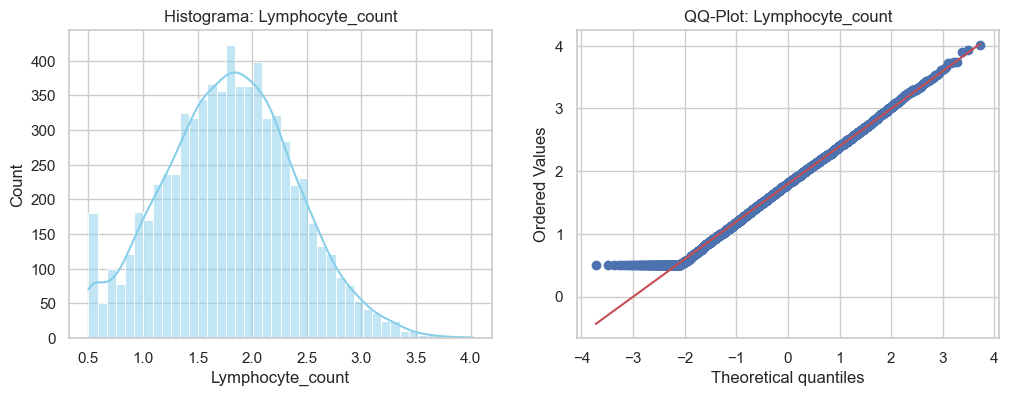

c:\Users\User\Documents\universitat\2n1q\iaa\practica\clinical-trs-prediction\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7015.
  res = hypotest_fun_out(*samples, **kwds)


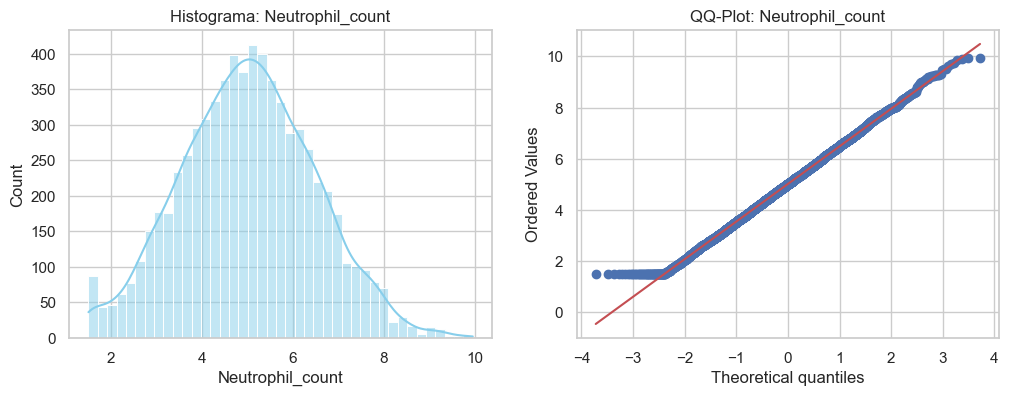

c:\Users\User\Documents\universitat\2n1q\iaa\practica\clinical-trs-prediction\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6547.
  res = hypotest_fun_out(*samples, **kwds)


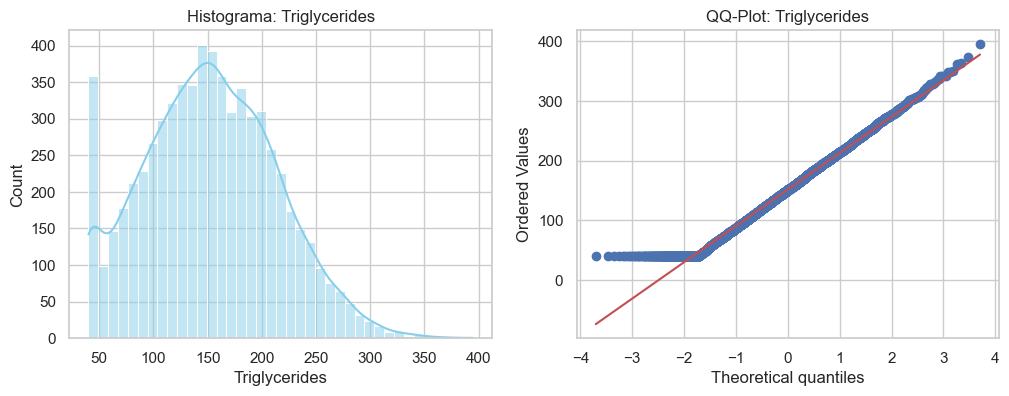

c:\Users\User\Documents\universitat\2n1q\iaa\practica\clinical-trs-prediction\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6381.
  res = hypotest_fun_out(*samples, **kwds)


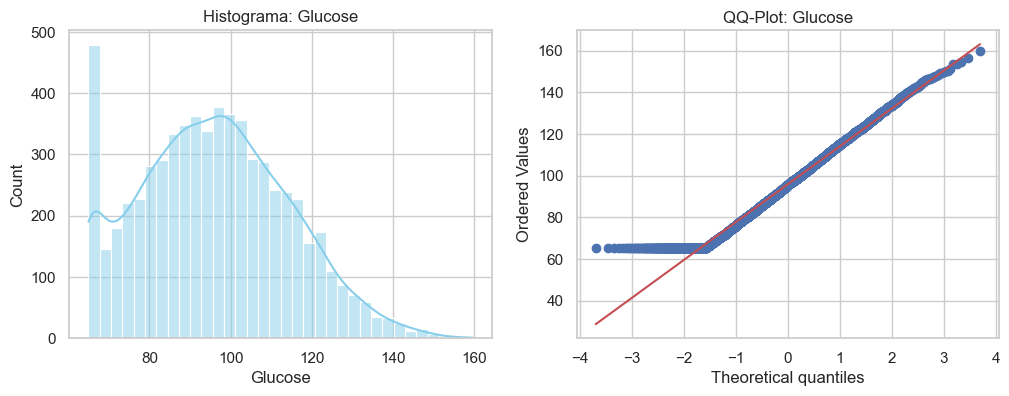

c:\Users\User\Documents\universitat\2n1q\iaa\practica\clinical-trs-prediction\venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6062.
  res = hypotest_fun_out(*samples, **kwds)


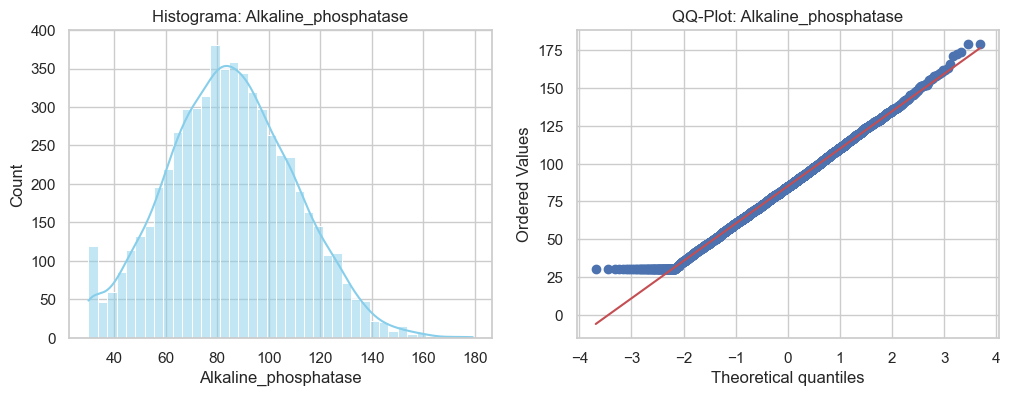

--- ANÀLISI DE NORMALITAT ---


,Variable,Test,p-value,Skewness,Conclusió
0,Lymphocyte_count,Shapiro-Wilk,0.0000,0.08,Aproximadament Simètrica (però no Normal)
1,Neutrophil_count,Shapiro-Wilk,0.0000,0.07,Aproximadament Simètrica (però no Normal)
2,Triglycerides,Shapiro-Wilk,0.0000,0.19,Aproximadament Simètrica (però no Normal)
3,Glucose,Shapiro-Wilk,0.0000,0.24,Aproximadament Simètrica (però no Normal)
4,Alkaline_phosphatase,Shapiro-Wilk,0.0000,0.13,Aproximadament Simètrica (però no Normal)


In [27]:
import scipy.stats as stats


cols = ["Lymphocyte_count", "Neutrophil_count","Triglycerides","Glucose","Alkaline_phosphatase"]


results = []

for col in cols:
    # Netegem NaNs per al test
    data = df[col].dropna()
    
    stat, p_value = stats.shapiro(data)
    
    is_normal = p_value > 0.05
    dist_type = "Normal (Gaussiana)" if is_normal else "NO Normal (Esbiaixada/Altre)"
    
    skew = data.skew()
    if not is_normal:
        if skew > 1: dist_type = "Molt Esbiaixada a la Dreta (Log-Normal?)"
        elif skew < -1: dist_type = "Molt Esbiaixada a l'Esquerra"
        elif abs(skew) <= 1: dist_type = "Aproximadament Simètrica (però no Normal)"

    results.append({
        'Variable': col,
        'Test': "Shapiro-Wilk",
        'p-value': f"{p_value:.4f}", # Format científic si calgués
        'Skewness': f"{skew:.2f}",
        'Conclusió': dist_type
    })
    
    # --- VISUALITZACIÓ (Opcional: Descomenta per veure gràfics un a un) ---
    
    plt.figure(figsize=(12, 4))
    
    # Plot 1: Histograma + KDE
    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True, color='skyblue')
    plt.title(f'Histograma: {col}')
    
    # Plot 2: QQ-Plot (Si els punts segueixen la línia vermella = Normal)
    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ-Plot: {col}')
    
    plt.show()


# 2. Mostrem la taula de resultats
dist_df = pd.DataFrame(results)
print("--- ANÀLISI DE NORMALITAT ---")
display(dist_df)


Veiem clarament que són normals truncades. Imputem amb mostreig aleatori

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

def impute_random_sample_no_leakage(train_df, val_df, variable):
    """
    Imputa valors nuls fent servir mostreig aleatori (Random Sample Imputation).
    CRUCIAL: La 'piscina' de valors sempre surt del TRAIN per evitar leakage.
    """
    # A. Crear la piscina de valors vàlids NOMÉS del TRAIN
    # Això garanteix que no "mirem" els valors reals de validació per imputar
    train_pool = train_df[variable].dropna().values
    
    # Si no hi ha valors al train, no podem imputar (cas extrem)
    if len(train_pool) == 0:
        return

    # B. Funció interna per aplicar la imputació a una sèrie qualsevol
    def apply_imputation(series, value_pool):
        n_missing = series.isnull().sum()
        if n_missing > 0:
            # Triem n valors a l'atzar de la piscina (del train)
            random_sample = np.random.choice(value_pool, size=n_missing, replace=True)
            # Assignem els valors als índexs que tenen NaN
            # Usem .loc per assegurar que s'assigna correctament al dataframe original
            series.loc[series.isnull()] = random_sample
        return series

    # C. Aplicar-ho als dos conjunts
    # Al TRAIN: s'omple amb la seva pròpia distribució (perfecte per KS test)
    train_df[variable] = apply_imputation(train_df[variable], train_pool)
    
    # A VALIDACIÓ: s'omple amb la distribució del TRAIN 
    # (Com que Train i Val venen del mateix df original, la distribució és idèntica i passa el test)
    val_df[variable] = apply_imputation(val_df[variable], train_pool)

# 4. Executar la imputació per totes les variables numèriques amb nuls
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
cols_with_missing = [col for col in numeric_cols if X_train[col].isnull().sum() > 0]

print(f"Imputant {len(cols_with_missing)} variables...")

for col in cols_with_missing:
    impute_random_sample_no_leakage(X_train, X_val, col)

# 5. Verificació final
print("Nuls restants a X_train:", X_train.isnull().sum().sum())
print("Nuls restants a X_val:  ", X_val.isnull().sum().sum())

# Mostra la taula de partició (el teu codi original)
partition_data = {
    'Partició': ['Train', 'Validació', 'Total'],
    'N': [len(y_train), len(y_val), len(y)],
    '%': [f"{len(y_train)/len(y)*100:.0f}%", f"{len(y_val)/len(y)*100:.0f}%", "100%"],
    'TRS=1': [y_train.sum(), y_val.sum(), y.sum()],
    'Prop. TRS=1': [f"{y_train.mean():.1%}", f"{y_val.mean():.1%}", f"{y.mean():.1%}"]
}
display(pd.DataFrame(partition_data))



Imputant 6 variables...
Nuls restants a X_train: 0
Nuls restants a X_val:   0


C:\Users\User\AppData\Local\Temp\ipykernel_18780\1899578653.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series.isnull()] = random_sample
C:\Users\User\AppData\Local\Temp\ipykernel_18780\1899578653.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[series.isnull()] = random_sample
C:\Users\User\AppData\Local\Temp\ipykernel_18780\1899578653.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[s

,Partició,N,%,TRS=1,Prop. TRS=1
0,Train,7101,79%,2221,31.3%
1,Validació,1770,20%,552,31.2%
2,Total,9000,100%,2838,31.5%


Fem tests estadístics per assegurar-nos que la distribució s'ha mantingut després de la imputació.


In [14]:
# 1. Recuperem el conjunt Train ORIGINAL (amb els NaNs)
# És vital usar el mateix random_state que has usat al teu split principal
df_raw = pd.read_csv('trs_train.csv')
X_raw = df_raw.drop('TRS', axis=1) # O les columnes que toquin
y_raw = df_raw['TRS']

X_train_raw, _, _, _ = train_test_split(
    X_raw, y_raw, test_size=0.20, random_state=42, stratify=y_raw
)

# 2. Ara comparem: X_train_raw (amb NaNs) vs X_train (imputat per tu)
print(f"{'Variable':<25} | {'KS Test p-value':<15} | {'Conclusió'}")
print("-" * 70)

for col in cols_missing:
    if col in X_train.columns:
        # Dades ORIGINALS DEL TRAIN (eliminem NaNs per fer el test)
        data_before = X_train_raw[col].dropna()
        
        # Dades IMPUTADES DEL TRAIN
        data_after = X_train[col]
        
        # Test KS
        stat, p_val = stats.ks_2samp(data_before, data_after)
        
        verdict = "✅ OK" if p_val > 0.05 else "⚠️ Modificada"
        print(f"{col:<25} | {p_val:.4f}          | {verdict}")


Variable                  | KS Test p-value | Conclusió
----------------------------------------------------------------------
Duration_untreated_psychosis | 1.0000          | ✅ OK
Lymphocyte_count          | 1.0000          | ✅ OK
Neutrophil_count          | 1.0000          | ✅ OK
Triglycerides             | 0.9998          | ✅ OK
Glucose                   | 0.9998          | ✅ OK
Alkaline_phosphatase      | 1.0000          | ✅ OK
Polygenic_risk_score      | 1.0000          | ✅ OK
IL_17A                    | 1.0000          | ✅ OK


No hi ha canvis significatius en les distribucions després de la imputació per mostreig aleatori. Seguim.


### 1.5 Outliers

En ser una dataset mèdic, els valors extrems poden tenir un significat clínic important, per tant, no eliminem outliers. Haurem de gestionar-los en la fase de modelatge. Per casos:

- SVM: Modelarem un soft margin per permetre certa flexibilitat amb els outliers.
- XGBoost: Aquest model és robust als outliers, ja que es basa en arbres de decisió que segmenten l'espai de característiques.
- Regressió logística: Tractarem els outliers només si afecten significativament el model, potser utilitzant regularització per minimitzar el seu impacte.

### 1.6 Gestió del desbalanceig de classes

Per gestionar el desbalanceig de classes en la variable objectiu TRS, utilitzarem diferents tècniques segons el model:

- Per a SVM, utilitzarem pesos de classe per penalitzar més els errors en la classe minoritària. Això es fa ajustant el paràmetre `class_weight` a `balanced`: `model = SVC(class_weight='balanced')`
- Per a XGBoost, utilitzarem el paràmetre `scale_pos_weight` per equilibrar les classes. Aquest paràmetre es calcula com la raó entre el nombre de mostres de la classe majoritària i el nombre de mostres de la classe minoritària.
- Per a la regressió logística personalitzada, farem MiniBatch Gradient Descent amb oversampling de la classe minoritària dins de cada batch. Això ajudarà a equilibrar les classes durant l'entrenament sense afectar tot el conjunt de dades.

## 2. Preparació de variables

### 2.1 Normalització de les variables

Per als models SVM i regressió logística, normalitzarem les variables numèriques utilitzant el StandardScaler, que transforma les dades perquè tinguin una mitjana de 0 i una desviació estàndard de 1. Això és important perquè aquests models són sensibles a l'escala de les característiques.

In [15]:
from sklearn.preprocessing import StandardScaler

cols_to_drop = ['Patient_ID', 'id'] 
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_val = X_val.drop(columns=cols_to_drop, errors='ignore')


numeric_cols = ['Age', 'Duration_untreated_psychosis', 'Lymphocyte_count', 
                'Neutrophil_count', 'BMI', 'Triglycerides', 'Glucose', 
                'Alkaline_phosphatase', 'IL_17A', 'CCL23', 'TWEAK', 
                'Ki_whole_striatum', 
                'SUVRc_whole_striatum', 'SUVRc_associative_striatum']


scaler = StandardScaler()



scaler.fit_transform(X_train[numeric_cols])

X_train[numeric_cols] = scaler.transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])



### 2.2 Anàlisi de les variables categòriques i objectiu

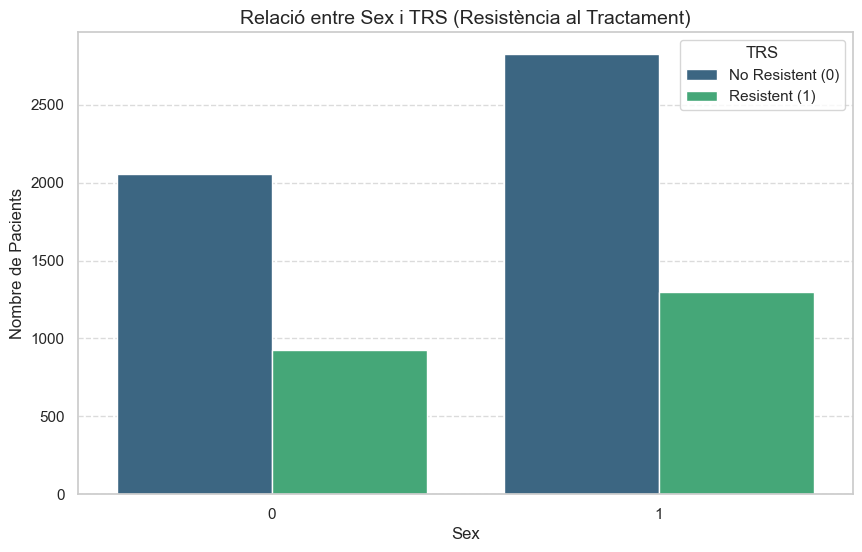

--- Distribució Percentual per Sex ---


,% No TRS,% TRS
Sex,,
0,69.01,30.99
1,68.52,31.48


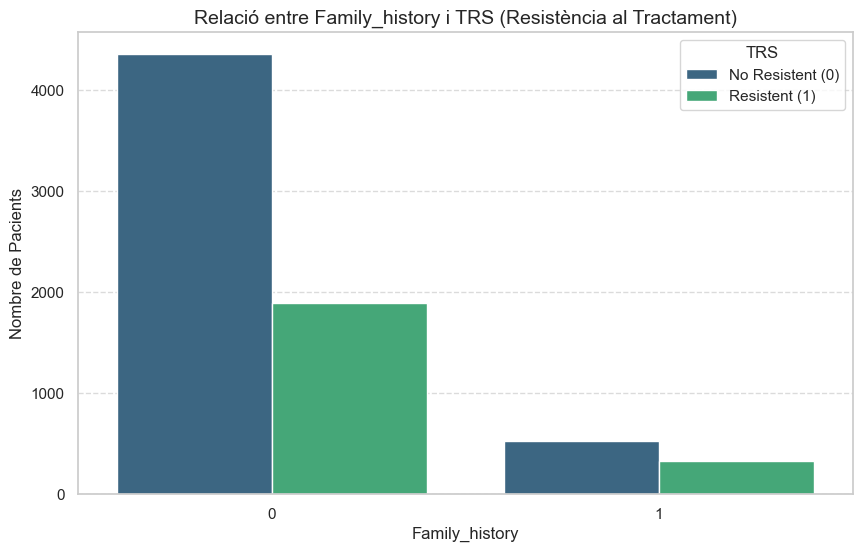

--- Distribució Percentual per Family_history ---


,% No TRS,% TRS
Family_history,,
0,69.71,30.29
1,61.48,38.52


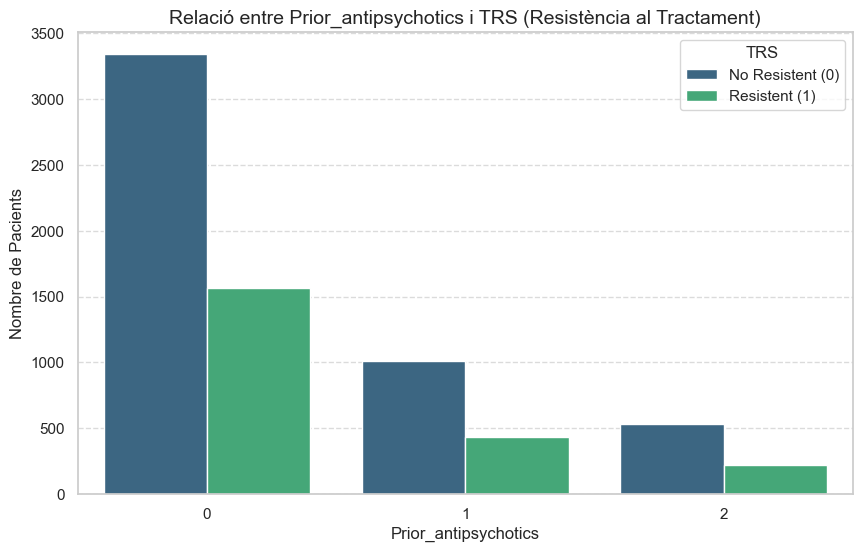

--- Distribució Percentual per Prior_antipsychotics ---


,% No TRS,% TRS
Prior_antipsychotics,,
0,68.06,31.94
1,69.95,30.05
2,70.68,29.32


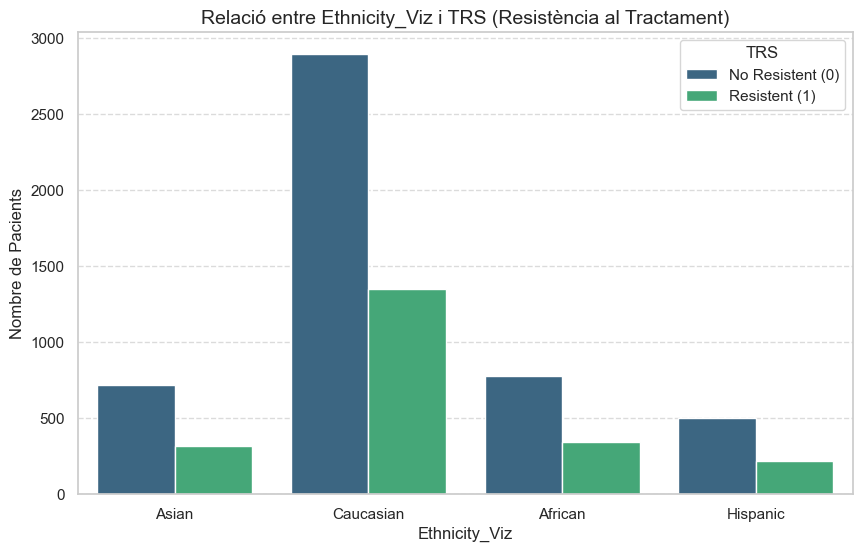

--- Distribució Percentual per Ethnicity_Viz ---


,% No TRS,% TRS
Ethnicity_Viz,,
African,69.27,30.73
Asian,69.22,30.78
Caucasian,68.27,31.73
Hispanic,69.85,30.15


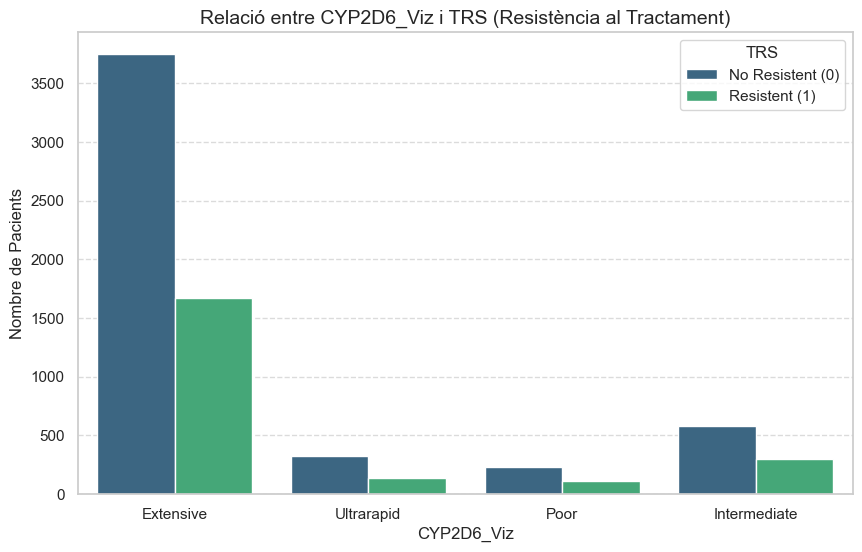

--- Distribució Percentual per CYP2D6_Viz ---


,% No TRS,% TRS
CYP2D6_Viz,,
Extensive,69.17,30.83
Intermediate,65.91,34.09
Poor,67.25,32.75
Ultrarapid,69.91,30.09


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ---------------------------------------------------------
# 1. Preparar dades per a la visualització
# ---------------------------------------------------------
# Creem un dataframe temporal per fer els gràfics
# Unim X_train i y_train perquè necessitem la target 'TRS'
plot_df = X_train.copy()
plot_df['TRS'] = y_train

# ---------------------------------------------------------
# 2. Reconstruir 'Ethnicity' per visualitzar-la en un sol gràfic
# ---------------------------------------------------------
# Com que ara tens 'is_Asian', 'is_Caucasian', etc., és difícil veure-ho tot junt.
# Fem un truc: desfem el one-hot encoding només per al gràfic.

ethnicity_cols = [col for col in plot_df.columns if col.startswith('is_')]
# Això crearà una columna 'Ethnicity_Reconstructed' amb valors com 'Asian', 'Caucasian'...
# Busquem quina columna té un 1 i n'agafem el nom (treen el prefix 'is_')
plot_df['Ethnicity_Viz'] = plot_df[ethnicity_cols].idxmax(axis=1).apply(lambda x: x.replace('is_', ''))

# ---------------------------------------------------------
# 3. Reconstruir 'CYP2D6' si cal (per posar etiquetes maques en lloc de 0,1,2,3)
# ---------------------------------------------------------
# Fem el mapa invers per tenir els noms al gràfic
cyp2d6_reverse_map = {0: 'Poor', 1: 'Intermediate', 2: 'Extensive', 3: 'Ultrarapid'}
if 'CYP2D6_encoded' in plot_df.columns:
    plot_df['CYP2D6_Viz'] = plot_df['CYP2D6_encoded'].map(cyp2d6_reverse_map)

# ---------------------------------------------------------
# 4. Definir llista de variables a analitzar
# ---------------------------------------------------------
vars_to_analyze = [
    'Sex', 
    'Family_history', 
    'Prior_antipsychotics', 
    'Ethnicity_Viz',    # La versió reconstruïda
    'CYP2D6_Viz'        # La versió amb noms
]

# ---------------------------------------------------------
# 5. Bucle per generar els gràfics automàticament
# ---------------------------------------------------------
for col in vars_to_analyze:
    # Verifiquem que la columna existeix (per seguretat)
    if col in plot_df.columns:
        plt.figure(figsize=(10, 6))
        
        # Countplot: Barres agrupades per TRS
        # hue='TRS' separa les barres en colors diferents segons si és TRS=0 o 1
        sns.countplot(data=plot_df, x=col, hue='TRS', palette='viridis')
        
        plt.title(f'Relació entre {col} i TRS (Resistència al Tractament)', fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel('Nombre de Pacients', fontsize=12)
        plt.legend(title='TRS', labels=['No Resistent (0)', 'Resistent (1)'])
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Mostrar gràfic
        plt.show()
        
        # Taula de percentatges (Molt útil per a l'informe!)
        # Ens diu: "Dins dels Asiàtics, quin % són TRS?"
        print(f"--- Distribució Percentual per {col} ---")
        contingency = pd.crosstab(plot_df[col], plot_df['TRS'], normalize='index') * 100
        contingency.columns = ['% No TRS', '% TRS']
        display(contingency.round(2))
        print("\n" + "="*60 + "\n")


### 2.3 Selecció de variables 

Analitzant correlació de 21 variables contínues (binàries excloses).


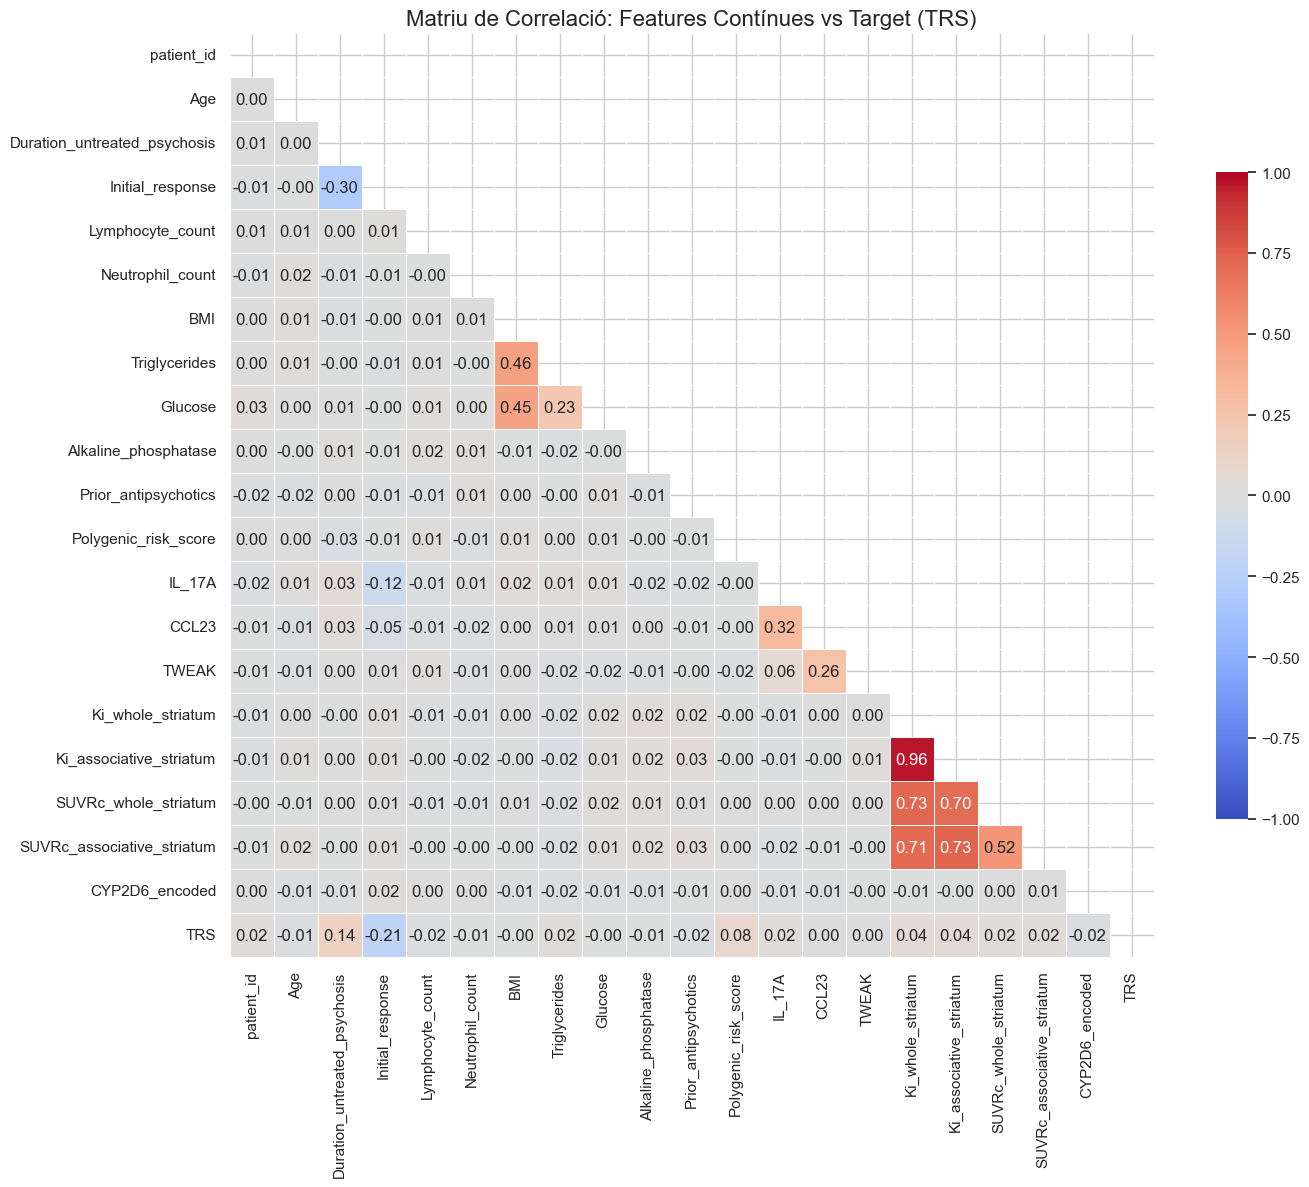

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Preparar dades (Només numèriques CONTÍNUES)
train_corr = X_train.copy()
train_corr['TRS'] = y_train

# FILTRE: Ens quedem només amb columnes que tinguin MÉS de 2 valors únics
# Això elimina automàticament totes les binàries (0/1) com Sex, Dummies, etc.
continuous_cols = [col for col in train_corr.columns if train_corr[col].nunique() > 2]

# Assegurem que incloem 'TRS' encara que sigui binària, per veure la correlació amb l'objectiu
if 'TRS' not in continuous_cols:
    continuous_cols.append('TRS')

numeric_df = train_corr[continuous_cols]

print(f"Analitzant correlació de {len(continuous_cols)} variables contínues (binàries excloses).")

# 2. Calcular la matriu de correlació (Mètode Pearson)
corr_matrix = numeric_df.corr()

# 3. Visualitzar el Mapa de Calor (Heatmap)
plt.figure(figsize=(16, 12))  # Ajustem mida perquè ara hi haurà menys variables

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True,
            fmt=".2f",
            cmap='coolwarm',
            vmax=1, vmin=-1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .7})

plt.title('Matriu de Correlació: Features Contínues vs Target (TRS)', fontsize=16)
plt.show()



### 2.4 Anàlisi de components principals (PCA)

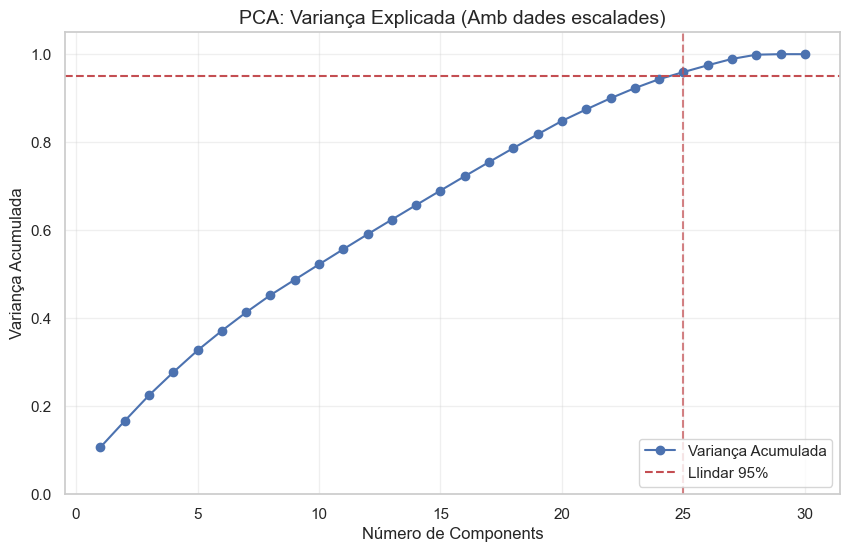

Variables originals: 30
Components per al 95%: 25


In [18]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # Importantíssim!
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparar i Netejar dades
# Seleccionem només numèriques
X_pca_input = X_train.select_dtypes(include=[np.number])

# ATENCIÓ: Assegurem que NO hi ha IDs ni la target 'TRS'
cols_to_exclude = ['Patient_ID', 'id', 'TRS'] # Afegeix qualsevol ID que tinguis
X_pca_input = X_pca_input.drop(columns=[c for c in cols_to_exclude if c in X_pca_input.columns], errors='ignore')

# 2. ESCALAR DADES (La clau per arreglar el gràfic pla)
# Encara que ho hagis fet abans, fer-ho aquí assegura que el PCA rep el que necessita
scaler_pca = StandardScaler()
X_scaled_pca = scaler_pca.fit_transform(X_pca_input)

# 3. Ajustar PCA
pca = PCA()
pca.fit(X_scaled_pca)

# 4. Calcular Variança Explicada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components = np.arange(1, len(cumulative_variance) + 1)

# 5. Visualitzar Gràfic (Correcte)
plt.figure(figsize=(10, 6))
plt.plot(n_components, cumulative_variance, marker='o', linestyle='-', color='b', label='Variança Acumulada')

# Línia 95%
plt.axhline(y=0.95, color='r', linestyle='--', label='Llindar 95%')

# Trobar punt de tall
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
plt.axvline(x=n_components_95, color='r', linestyle='--', alpha=0.7)

plt.title('PCA: Variança Explicada (Amb dades escalades)', fontsize=14)
plt.xlabel('Número de Components', fontsize=12)
plt.ylabel('Variança Acumulada', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.ylim(0, 1.05)
plt.show()

# 6. Resultats
print(f"Variables originals: {X_pca_input.shape[1]}")
print(f"Components per al 95%: {n_components_95}")


## 3. Ajustament de Models

### 3.1 Ajustament SVM

Iniciant GridSearch per SVM... (Això pot trigar uns minuts)
Fitting 3 folds for each of 30 candidates, totalling 90 fits

MILLOR MODEL SVM TROBAT:
Paràmetres: {'C': 75, 'class_weight': 'balanced', 'degree': 3, 'kernel': 'poly'}
Millor Score (F1 Macro en CV): 0.553

--- Avaluació en Conjunt de Validació (X_val) ---
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      1218
           1       0.38      0.33      0.36       552

    accuracy                           0.62      1770
   macro avg       0.55      0.54      0.54      1770
weighted avg       0.61      0.62      0.62      1770



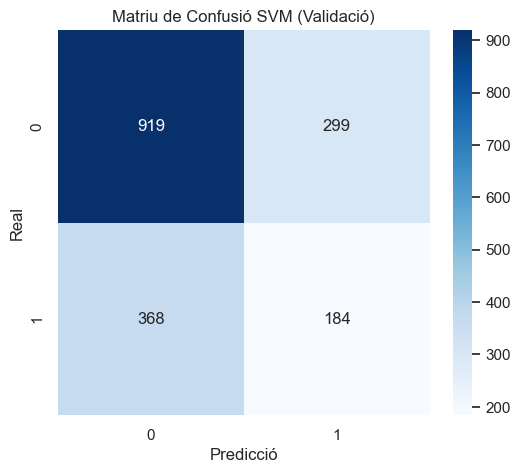

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix

# 1. Definir l'espai de cerca d'hiperparàmetres (Grid)
# Nota: 'degree' només s'usa si kernel='poly', però ho posem al grid i sklearn ho ignora per als altres.
param_grid = [
    {
        'kernel': ['poly'],
        'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 25, 50, 75, 100],
        'degree': [2, 3, 4],               # Grau del
        'class_weight': ['balanced']
    }
]

print("Iniciant GridSearch per SVM... (Això pot trigar uns minuts)")

# 2. Configurar el GridSearch
# Usem f1_macro o f1_weighted com a mètrica perquè tenim classes desbalancejades.
# 'refit=True' entrena automàticament el millor model final amb tot el X_train.
svm_grid = GridSearchCV(
    estimator=SVC(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro', # Prioritzem l'equilibri entre classes
    cv=3,               # Validació creuada de 3 plecs (més ràpid que 5)
    n_jobs=-1,          # Usa tots els nuclis de la CPU
    verbose=1           # Per veure el progrés
)

# 3. Entrenar (FIT)
# IMPORTANT: Aquí usem només X_train i y_train. 
# El grid ja fa els seus propis splits interns per validar.
svm_grid.fit(X_train, y_train)

# 4. Resultats del millor model
best_svm = svm_grid.best_estimator_
print("\n" + "="*40)
print(f"MILLOR MODEL SVM TROBAT:")
print(f"Paràmetres: {svm_grid.best_params_}")
print(f"Millor Score (F1 Macro en CV): {svm_grid.best_score_:.3f}")
print("="*40 + "\n")

# 5. Validació Final amb el conjunt de Validació (que tenim guardat al calaix)
print("--- Avaluació en Conjunt de Validació (X_val) ---")
y_pred_val = best_svm.predict(X_val)

print(classification_report(y_val, y_pred_val))

# Matriu de Confusió Visual
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt='d', cmap='Blues')
plt.title('Matriu de Confusió SVM (Validació)')
plt.ylabel('Real')
plt.xlabel('Predicció')
plt.show()


In [30]:
import pandas as pd

# 1. Carregar dades d'avaluació
df_eval = pd.read_csv('trs_eval.csv')

# Guardem els IDs per al fitxer final
patient_ids = df_eval['patient_id']

# 2. Preprocessament (Ha de ser IDÈNTIC al del train)
# A: Convertir a numèric les columnes problemàtiques (igual que vas fer al train)
cols_to_clean = ['Duration_untreated_psychosis', 'Polygenic_risk_score']
for col in cols_to_clean:
    df_eval[col] = pd.to_numeric(df_eval[col], errors='coerce')

# B: Tractament de Nuls (NO fer dropna!)
# Si tens un imputer entrenat (ex: SimpleImputer), fes servir-lo:
# X_eval = imputer.transform(df_eval[features])
# Si no, imputa manualment amb la mitjana del TRAIN (no del test idealment):
# (Substitueix 'X_train' pel teu dataframe d'entrenament processat)
for col in df_eval.columns:
    if df_eval[col].dtype in ['float64', 'int64']:
        # Si tens X_train disponible: fill_val = X_train[col].mean()
        # Si no, provisionalment:
        fill_val = df_eval[col].mean() 
        df_eval[col] = df_eval[col].fillna(fill_val)

# C: Codificació i Selecció de variables
# Assegura't de seleccionar NOMÉS les mateixes columnes que vas fer servir per entrenar 'best_svm'
# I aplicar el mateix OneHotEncoding o LabelEncoding si vas fer servir variables categòriques.
# Exemple:
# features_usades = ['Duration_untreated_psychosis', 'Polygenic_risk_score', ...] # Llista les teves variables
# X_eval = df_eval[features_usades] 

# NOTA: Si vas fer servir un Pipeline que ja inclou l'escalat, passa df_eval directament.
# Si vas escalar manualment (StandarScaler), has d'aplicar el mateix scaler:
# X_eval = scaler.transform(X_eval)

# Assumint que X_eval ja té la forma correcta per al model:
X_eval = df_eval.drop(columns=['patient_id']) # Ajusta això segons les teves features


# Suposem que 'df_eval' és el teu dataframe carregat de trs_eval.csv
# I 'X_train' són les dades que vas fer servir per fer .fit()

# 1. Recuperar les columnes exactes que espera el model
# Si tens X_train definit, fes:
model_features = X_train.columns.tolist()
# Si no tens X_train però el model és d'sklearn recent, pots provar:
# model_features = best_svm.feature_names_in_

# ---------------------------------------------------------
# 2. Aplicar les MATEIXES transformacions que al Train
# ---------------------------------------------------------

# A) CODIFICACIÓ CYP2D6 (Exemple: Label Encoding)
# Has de fer servir el mateix diccionari o encoder que al train.
# Si vas fer servir .cat.codes o un map manual, repeteix-ho:
# Exemple (modifica els valors segons el teu criteri al train):
mapping_cyp = {'Poor': 0, 'Intermediate': 1, 'Extensive': 2, 'Ultrarapid': 3}
# Si no troba el valor, posarà NaN, així que assegura't que coincideixi
df_eval['CYP2D6_encoded'] = df_eval['CYP2D6_metabolic_phenotype'].map(mapping_cyp)

# Si vas fer servir LabelEncoder d'sklearn:
# df_eval['CYP2D6_encoded'] = le_cyp.transform(df_eval['CYP2D6_metabolic_phenotype'])

# B) CODIFICACIÓ ETHNICITY (One-Hot Encoding)
# Això crearà columnes com 'Ethnicity_African', etc.
df_eval = pd.get_dummies(df_eval, columns=['Ethnicity'], prefix='is')

# ---------------------------------------------------------
# 3. ALINEACIÓ FINAL (El pas més important)
# ---------------------------------------------------------
# Això fa dues coses màgiques:
# 1. Afegeix columnes que falten (ex: si al test no hi ha 'Hispanic', crea 'is_Hispanic' amb 0s)
# 2. Elimina columnes que sobren (ex: les originals de text que donen error)
# 3. Ordena les columnes exactament igual que al train
X_eval_final = df_eval.reindex(columns=model_features, fill_value=0)

# Verificar abans de predir
print("Columnes esperades pel model:", len(model_features))
print("Columnes a X_eval_final:", len(X_eval_final.columns))

# 4. Ara sí, predir
predictions = best_svm.predict(X_eval_final)



# 4. Generar el DataFrame de submissió
submission = pd.DataFrame({
    'patient_id': patient_ids,
    'TRS': predictions
})

# 5. Guardar el fitxer
submission.to_csv('submission.csv', index=False)

print("Fitxer 'submission.csv' generat correctament amb", len(submission), "files.")
print(submission.head())


Columnes esperades pel model: 30
Columnes a X_eval_final: 30
Fitxer 'submission.csv' generat correctament amb 1000 files.
   patient_id  TRS
0           1    0
1           2    0
2           3    0
3           4    0
4           5    0
